# Restrictive scalar particles in Russian

## Table of Contents
1. [Research idea](#1.-Research-idea)
2. [The plan](#2.-The-plan)
3. [Inspecting standalone particles](#3.-Inspecting-standalone-particles) <br>
    3.1. [Data collection](#3.1.-Data-collection) <br>
    3.2. [Data annotation](#3.2.-Data-annotation) <br>
    3.3. [Data analysis](#3.3.-Data-analysis) <br>
    3.4. [Interim summary](#3.4.-Interim-summary)
4. [Combinations of particles](#4.-Combinations-of-particles) <br>
    4.1. [Data collection](#4.1.-Data-collection) <br>
    4.2. [Data annotation](#4.2.-Data-annotation) <br>
    4.3. [Visualization](#4.3.-Visualization) <br>
    4.4. [Summary](#4.4.-Summary-on-particle-combinations)
5. [Conclusions](#5.-Conclusions)

## 1. Research idea

*Restrictive scalar particles* are a kind of expressions that are sensitive to focus placement. These particles associate with an element *in focus* (prosodically marked element) and make an utterance implicate that (a) the element they associate with is the lowest element on some contextually-provided scale, (b) the stronger alternatives of the utterance (i. e. containing elements higher on the abovementioned scale) are false.

The English language has at least three particles of this kind coexisting within a language: *only*, *merely*, *just*. However, one can notice that their distributional and semantic properties are somewhat different (see table below; acceptability judgements are very preliminary and are based on author's introspection).


|   Particle	|   Example	|
|:---	|:---	|
|   *only*	|   *He has only two children.* |
|   	|   *She is only a waitress.* | 
|   	|  *Only John came.* |
|   	|  *The program only works with .txt documents.* |
|   *merely*	|   \* *He has merely two children.* |
|   	|   *She is merely a waitress.* | 
|   	|  \* *Merely John came.* |
|   	|  \? *The program merely works with .txt documents.* |
|   *just*	|   *He has just two children.* |
|   	|   *She is just a waitress.* | 
|   	|  \? *Just John came.* |
|   	|  \? *The program just works with .txt documents.* |

In Russian, there are several restrictive scalar particles, as well: 'только', 'лишь', 'всего', 'именно'.

Within this project I would like to have a look at these four particles and answer the following questions:
1. Do they have some preferences with regard to their associate (POS, syntactic position)?
2. Some of these particles can combine with each other ('всего лишь', 'всего только', 'только лишь'). What combinations and orders are possible and how frequent these combinations are?
3. What preferences (see bullet 1) do combinations of these particles have? Do they inherit the properties of one of its parts or have a completely different distribution?


## 2. The plan

1. Inspect standalone particles <br>
    1.1. Collect the data for each particle from [the Russian National Corpus](https://ruscorpora.ru/new/), filtering out the examples with homonymous expressions and cases of particle combinations. <br>
    1.2. Enrich the data with POS tagging and some syntactic analysis. <br>
    1.3. Analyze the compatibility of different particles with associates of different parts of speech and of different syntactic roles. <br>
    1.4. Make preliminary conclusions.
2. Inspect combinations of particles<br>
    2.1. Collect the data<br>
    2.2. Analyze the frequencies of combinations<br>
    2.3. Enrich the data<br>
    2.4. Analyze the compatibility<br>
    2.5. Make conclusions
3. Sum everything up



## 3. Inspecting standalone particles
### 3.1. Data collection

Let us write a function that works with the RNC and downloads the query results from the specified amount of pages. 

By default, each result page contains 10 documents, but a document can contain more than one occurence of the particle.
We do not want to analyze relative frequencies (this would be, for instance, a ratio of a particle used with numerals to a total number of occurrences) since this would require us to download all of the utterances for each particle, which is too many. Thus, we are going to only take one example from each document and make the number of examples equal for each particle.

In [3]:
import re
import pandas as pd 
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup

def ruscorpora_extractor(pages_num, url):
    
    # pretend to be a browser
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' 
    examples = []

    # collect data from each page
    for page in tqdm(range(pages_num)):
     
        page = requests.get(url+ "&p=" + str(page), headers={'User-Agent':user_agent})
        soup = BeautifulSoup(page.text, 'html.parser')
        
        # navigating the page
        example_doc = soup.find("ol").find_all('table')
        
        # from each document take only one example
        for doc in example_doc:            
            ex = doc.find('li') 
            
            # get rid of the metadata
            unwanted = ex.find_all(class_= ["doc", "on", "prev", "b-kwic-expl"])
            for unw in unwanted: 
                unw.clear()
                
            example = ex.get_text().strip()
            examples.append(example)
            
    # write data to a dataframe
    output = pd.DataFrame({"text": examples})
    # data.to_csv(output_file+".csv", encoding='utf-8-sig')
    return output

I wanted to use multiple-worded queries with regular expressions. Generating URLs for such queries is somewhat complex for RNC, so I've decided to work with "ready-to-use" links. I got these by making relevant queries (see below) with the RNC interface and copying URLs after the results are shown. I included some constraints on a preceding word and the following one to make sure that I get instances of standalone particles, and I get as few irrelevant examples as possible.

Here are the queries I used: <br>
`lish_url` <br>
word1: -(лишь|только|всего|именно) <br>
word2: лишь <br>
word3: -(лишь|только|всего|именно) 

`vsego_url`\* <br>
word1: -(лишь|только|всего|именно|прежде), gram1: -comp <br>
word2: всего <br>
word3: -(лишь|только|всего|именно) 

`tolko_url`\** <br>
word1: -(вот|пусть|как|лишь|только|всего|именно)<br>
word2: только <br>
word3: -(лишь|только|всего|именно|что) 

`imenno_url`\*** <br>
word1: -(а|лишь|только|всего|именно) <br>
word2: именно <br>
word3: -(лишь|только|всего|именно)

---
\* I included the constraint -comp for the first word to filter out examples with idiomatic constructions, such as 'больше всего', 'скорее всего', 'чаще всего' and others. For the same reason a preposition 'прежде' is added to the word1 group. However, I did't find a way to exclude another homonymous analysis, when 'всего' means 'in sum' as in a following sentence: "*Кроме руководителей компаний, на форум приехали и представители госструктур, всего около 100 человек.*". Nor did I manage to exclude 'всего' as a form of the word 'весь' meaning 'whole' as in a sentence "*Тут сидят представители фермеров со всего Львовского района.*"

\*\* I added 'вот', 'пусть' and 'как' to the word1 exclusion group to avoid examples, where 'только' is used in some other functions which are not relevant for me now: 'вот только', 'пусть только (попробует)', 'как только'.

\*\*\* I added 'а' to the word1 exclusion group to avoid examples, where 'именно' is used to further extend the some part of the utterance as in a sentence: "*Чаще всего речь идёт о более тонких материях, а именно об общественном сознании и его феноменах.*". Unfortunally, this has ruled out some relevant examples as well, e.g. "*На выходе необходим не скелет, нуждающийся в обязательной серьёзной литературной обработке, а именно текст.*"


Here are the links.

In [6]:
lish_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=10&spp=50&spd=10&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=-%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm1=&sem1=&flags1=&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%D0%BB%D0%B8%D1%88%D1%8C&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2=&parent3=0&level3=0&min3=1&max3=1&lex3=-%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm3=&sem3=&flags3=&sem-mod3=sem&sem-mod3=semx&morph3='
vsego_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=10&spp=50&spd=10&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=-%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%7C%D0%BF%D1%80%D0%B5%D0%B6%D0%B4%D0%B5%29&gramm1=-comp&sem1=&flags1=&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%D0%B2%D1%81%D0%B5%D0%B3%D0%BE&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2=&parent3=0&level3=0&min3=1&max3=1&lex3=-%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm3=&sem3=&flags3=&sem-mod3=sem&sem-mod3=semx&morph3='
tolko_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=10&spp=50&spd=10&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=-%28%D0%B2%D0%BE%D1%82%7C%D0%BF%D1%83%D1%81%D1%82%D1%8C%7C%D0%BA%D0%B0%D0%BA%7C%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm1=&sem1=&flags1=&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2=&parent3=0&level3=0&min3=1&max3=1&lex3=-%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%7C%D1%87%D1%82%D0%BE%29&gramm3=&sem3=&flags3=&sem-mod3=sem&sem-mod3=semx&morph3='
imenno_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=10&spp=50&spd=10&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=-%28%D0%B0%7C%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm1=&sem1=&flags1=&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2=&parent3=0&level3=0&min3=1&max3=1&lex3=-%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm3=&sem3=&flags3=&sem-mod3=sem&sem-mod3=semx&morph3='

Now let's collect the data for each query.  I will collect 100 examples for each particle, hence 10 result pages. <br>
**! Warning: scrapping takes some time.**

In [5]:
lish_df = ruscorpora_extractor(20, lish_url)

  0%|                                                    | 0/20 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'find_all'

In [11]:
lish_df

,text
0,"[shilo_83 (nick)] )) Не заладилось, потому как..."
1,"[Rud (nick)] Надевая колготки – синие, шерстя..."
2,[awesom13] Каждая семья здесь имеет свою исто...
3,[karelea (жен)] В нём душ родных вовек не сос...
4,[Andron (муж)] Даже определение «классика» не...
...,...
195,"Величины pH меньше 4 выдерживают лишь мхи, вер..."
196,Поэтому ответить читательнице могу лишь одно: ...
197,Исключение составляет лишь досрочное расторжен...
198,"И доходит она (быстро, надо сказать, доходит) ..."


In [12]:
vsego_df = ruscorpora_extractor(20, vsego_url)

100%|███████████████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


In [13]:
tolko_df = ruscorpora_extractor(20, tolko_url)

100%|███████████████████████████████████████████| 20/20 [01:25<00:00,  4.28s/it]


In [14]:
imenno_df = ruscorpora_extractor(20, imenno_url)

100%|███████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


In [17]:
lish_df.to_csv("ptcl_lish-orig.csv", index=None)
vsego_df.to_csv("ptcl_vsego-orig.csv", index=None)
imenno_df.to_csv("ptcl_imenno-orig.csv", index=None)
tolko_df.to_csv("ptcl_tolko-orig.csv", index=None)

### 3.2. Data annotation 
Now we are going to enrich the data with the following information: 

* Dependency type of the particle
* The word that the particle associates with (*an associate*)
* POS of the associate
* Dependency type of the associate


#### 3.2.1. Prior experimentation

Typically, focus-sensitive particles in Russian are linearly adjacent to their associates (partly, due to the relatively free word order in Russian). But this is not always the case. For instance, when associated with N, these particles linearly attach to the whole NP (i.e. to the modifiers of N). They also cannot penetrate PP, when associated with an N or an NP, embedded in it.

Because of these peculiarities, we will try to determine an associate of a particle, based on their syntactic dependencies (in the form that is employed in SpaCy), rather than count on linear order.

Let's play with some examples and see if SpaCy gives us any meaningful results.


In [27]:
ex_text_1 = "«От себя» добавляю только мелко нарезанный укроп." 
ex_text_2 = "Оставалось только попросить его уйти." 
ex_text_3 = "― В России всего восемь регионов, где финансовые дела обстоят относительно благополучно." 
ex_text_4 = "так дурной вкус в искусстве радуется лишь эффектному орнаменту и не откликается на естественную красоту"  
ex_text_5 = 'Ты наносишь капельку только тонкой кисточкой.' 
ex_text_6 = 'Он только зашел укрыться от дождя.' 
ex_text_7 = 'Меня отпустили всего на несколько дней.' 

In [28]:
import spacy
nlp_ru = spacy.load("ru_core_news_sm")

Here's a function that collects everything we are interested in for a relevant word (particle, in our case), and returns a dictionary with collected information.

We discriminate between <br>
an `immediate constituent` – the one a particle linearly attaches to;<br>
a `higher constituent` – if the immediate constituent is a modifier of some sort, the higher constituent is a head of this modifier, otherwise, the same as an immediate constituent;<br>
an `assosiate_phrase` – a subtree of an immediate constituent or, if it's a modifier, of a higher constituent (more or less a syntactic phrase that a particle attaches to).

In [29]:
def is_modifier(tag):
    tag = tag.split(':')[0]

    # mod is for nmod, amod, nummod
    # acl: clausal modifier
    # appos: appositional modifier
    if tag[-3:] == 'mod' in tag or 'acl' in tag or 'appos' in tag: 
        return True
    else:
        return False
    
    
def collect_word_info(spacy_model, txt, target_word): 
    doc = spacy_model(txt)
    
    for token in doc:
        # identify a target word and collect data for it
        if token.text.lower() == target_word:
        
            true_head = token.head
            
            # check if the head is a modifier, if it is, consider this modifier's head a new head
            # this is needed to identify cases where a particle assosiates with a more-than-one-word constituent 
            while is_modifier(true_head.dep_) != False:
                 true_head = true_head.head
        
            # find the constituent that the particle attaches to 
            if true_head.dep_ == "ROOT": 
                subtree_list = [token.head.text] 
            
            else:
                subtree = true_head.subtree
                subtree_list = []
                for t in subtree: 
                    if t.text != target_word:
                        subtree_list.append(t.text)
                    
            head_dict = {
                    "orig_sentence": txt,
                    "token" : token.text.lower(),
                    "dep_type" : token.dep_,
                    "pos" : token.pos_,

                    "immediate_head_text" : token.head.text,
                    "immediate_head_pos" : token.head.pos_, 
                    "immediate_head_dep_type" : token.head.dep_,

                    "higher_head_text" : true_head.text,
                    "higher_head_pos" : true_head.pos_, 
                    "higher_head_dep_type" : true_head.dep_, 

                    "assosiate_phrase" : ' '.join(subtree_list),
                    "assosiate_phrase_n" : len(subtree_list)
            }
            break 
        
    return head_dict

In [30]:
print(collect_word_info(nlp_ru, ex_text_1, "только"))
print(collect_word_info(nlp_ru, ex_text_2, "только"))
print(collect_word_info(nlp_ru, ex_text_3, "всего"))
print(collect_word_info(nlp_ru, ex_text_4, "лишь"))
print(collect_word_info(nlp_ru, ex_text_5, "только"))
print(collect_word_info(nlp_ru, ex_text_6, "только"))
print(collect_word_info(nlp_ru, ex_text_7, "всего"))

{'orig_sentence': '«От себя» добавляю только мелко нарезанный укроп.', 'token': 'только', 'dep_type': 'advmod', 'pos': 'PART', 'immediate_head_text': 'мелко', 'immediate_head_pos': 'ADV', 'immediate_head_dep_type': 'advmod', 'higher_head_text': 'укроп', 'higher_head_pos': 'NOUN', 'higher_head_dep_type': 'obj', 'assosiate_phrase': 'мелко нарезанный укроп', 'assosiate_phrase_n': 3}
{'orig_sentence': 'Оставалось только попросить его уйти.', 'token': 'только', 'dep_type': 'advmod', 'pos': 'PART', 'immediate_head_text': 'попросить', 'immediate_head_pos': 'VERB', 'immediate_head_dep_type': 'csubj', 'higher_head_text': 'попросить', 'higher_head_pos': 'VERB', 'higher_head_dep_type': 'csubj', 'assosiate_phrase': 'попросить его уйти', 'assosiate_phrase_n': 3}
{'orig_sentence': '― В России всего восемь регионов, где финансовые дела обстоят относительно благополучно.', 'token': 'всего', 'dep_type': 'advmod', 'pos': 'PART', 'immediate_head_text': 'восемь', 'immediate_head_pos': 'NUM', 'immediate_he

It works quite fine. If a particle attaches to the one-word constituent, we will see that its immediate head, higher head, and associate phase will coincide.

Unfortunately, there seems to be no way to determine the size of a constituent particle associates with (cf. 'всего восемь'). Also, some sentences are ambiguous in natural language, too. We will try to take into account different parameters when we investigate frequencies.

#### 3.2.2. Data enrichment

Now let's update the data frames.


In [31]:
vsego_df_updated = pd.DataFrame()
for text in vsego_df["text"]: 
    info = collect_word_info(nlp_ru, text, "всего")
    vsego_df_updated = vsego_df_updated.append(info, ignore_index=True)

vsego_df_updated.head()

NameError: name 'vsego_df' is not defined

In [27]:
tolko_df_updated = pd.DataFrame()
for text in tolko_df["text"]: 
    info = collect_word_info(nlp_ru, text, "только")
    tolko_df_updated = tolko_df_updated.append(info, ignore_index=True)

tolko_df_updated.head()

,orig_sentence,token,dep_type,pos,immediate_head_text,immediate_head_pos,immediate_head_dep_type,higher_head_text,higher_head_pos,higher_head_dep_type,assosiate_phrase,assosiate_phrase_n
0,[Шведов_ВВ (nick)] Моя работа приносит мне не...,только,fixed,PART,не,PART,cc,не,PART,cc,не,1.0
1,[BigKat (nick)] А-ля греческий: Брынзу (я пок...,только,advmod,PART,заправки,NOUN,obl,заправки,NOUN,obl,после заправки,2.0
2,"[Kachora (nick)] А еще ходить на пары все, и ...",только,advmod,PART,тогда,ADV,advmod,Kachora,PROPN,ROOT,тогда,1.0
3,[alla (nick)] А объясняют это следующим образ...,только,advmod,PART,%,SYM,obl,%,SYM,obl,"на 30 % , а не на все 100",9.0
4,"[Rud (nick)] В книге реально описаны события,...",только,advmod,PART,слезы,NOUN,nsubj,слезы,NOUN,nsubj,слезы,1.0


In [28]:
imenno_df_updated = pd.DataFrame()
for text in imenno_df["text"]: 
    info = collect_word_info(nlp_ru, text, "именно")
    imenno_df_updated = imenno_df_updated.append(info, ignore_index=True)

#imenno_df_updated.head()

In [29]:
lish_df_updated = pd.DataFrame()
for text in lish_df["text"]: 
    info = collect_word_info(nlp_ru, text, "лишь")
    lish_df_updated = lish_df_updated.append(info, ignore_index=True)

#lish_df_updated.head()

I will also save these dataframes locally.

In [30]:
lish_df_updated.to_csv("ptcl_lish-annotated.csv", index=None)
vsego_df_updated.to_csv("ptcl_vsego-annotated.csv", index=None)
imenno_df_updated.to_csv("ptcl_imenno-annotated.csv", index=None)
tolko_df_updated.to_csv("ptcl_tolko-annotated.csv", index=None)

### 3.3. Data analysis

#### 3.3.1. Preliminary
Let's have a look at some raw numbers. <br>
Firstly, I would like to see if there is any difference in POS between an immediate head and a higher one (just to see if this distinction makes sense at all).

In [31]:
print('--vsego--')
print(vsego_df_updated['immediate_head_pos'].value_counts())
print(vsego_df_updated['higher_head_pos'].value_counts())

print('--tolko--')
print(tolko_df_updated['immediate_head_pos'].value_counts())
print(tolko_df_updated['higher_head_pos'].value_counts())


--vsego--
NUM      118
NOUN      55
VERB       9
ADV        6
SYM        4
DET        3
ADJ        2
PRON       2
PROPN      1
Name: immediate_head_pos, dtype: int64
NOUN     149
NUM       14
VERB      10
SYM        7
PROPN      4
ADV        4
ADJ        4
PRON       4
DET        3
X          1
Name: higher_head_pos, dtype: int64
--tolko--
NOUN     61
PART     59
VERB     20
ADV      14
NUM      13
ADJ      11
DET       7
PRON      7
PROPN     7
SYM       1
Name: immediate_head_pos, dtype: int64
NOUN     82
PART     59
VERB     23
PROPN     9
PRON      9
DET       7
SYM       6
ADJ       2
NUM       2
ADV       1
Name: higher_head_pos, dtype: int64


<br>

**Some observations**: 
1. Some of the differences between immediate and higher head properties are the results of the decisions we made earlier. For instance, ADJs, NUMs, and ADVs are not numerous among the higher heads, because those are typically modifiers. 

2. Particles do differ concerning the preferrable parts of speech of their associates. If we look at the numbers for immediate heads, 'всего' tend to combine with NUMs whereas 'только' does not typically combine with them. On the contrary, ADVs and VERBs are used with 'только' more frequently than with 'всего'. 

Also, let's see what the size of constituents can show us: 

In [32]:
print(vsego_df_updated['assosiate_phrase_n'].value_counts().head())
print(tolko_df_updated['assosiate_phrase_n'].value_counts().head())
print(lish_df_updated['assosiate_phrase_n'].value_counts().head())
print(imenno_df_updated['assosiate_phrase_n'].value_counts().head())

2.0    44
1.0    30
3.0    27
4.0    24
5.0    19
Name: assosiate_phrase_n, dtype: int64
1.0    91
3.0    23
2.0    18
5.0    13
4.0     7
Name: assosiate_phrase_n, dtype: int64
1.0    40
4.0    26
3.0    25
2.0    25
6.0    11
Name: assosiate_phrase_n, dtype: int64
1.0    76
3.0    27
2.0    20
4.0    12
5.0    12
Name: assosiate_phrase_n, dtype: int64


It seems, some particles tend to attach to modified constituents (either associating with an embedded element or with the whole NP) (всего, лишь), whereas others behave more or less indifferently to the size of the constituent (только, именно). (Generally, we expect smaller constituents to have higher numbers). 

#### 3.3.2. Visualization


Let's now visualize the differences properly.

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [34]:
particles_all = pd.DataFrame()

# create the dataframe containing the data on all particles
frames = [vsego_df_updated, imenno_df_updated, tolko_df_updated, lish_df_updated]
particles_all = pd.concat(frames)
len(particles_all)

800

Firstly, let's see POS preferences for an immediate and a higher head. 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


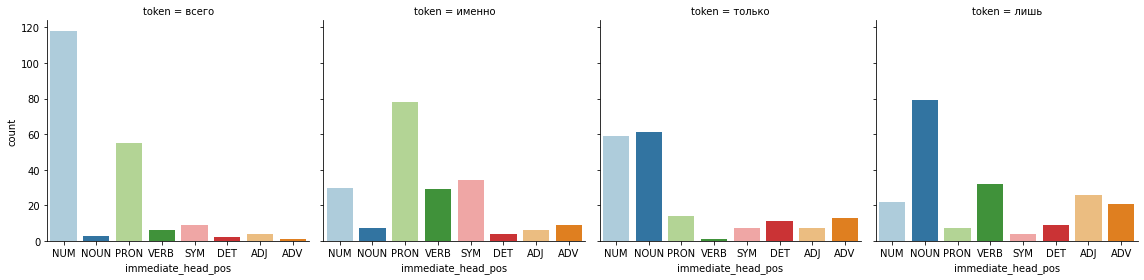

In [35]:
g = sns.FacetGrid(particles_all, col="token", height=4, aspect=1)
g.map(sns.countplot, 'immediate_head_pos', palette = "Paired")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


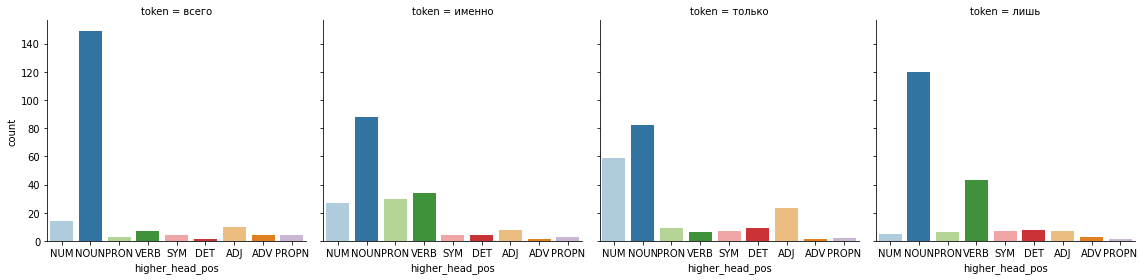

In [36]:
g = sns.FacetGrid(particles_all, col="token", height=4, aspect=1)
g.map(sns.countplot, 'higher_head_pos', palette = "Paired")

Some observations made based on these figures are reported in [a summary table](#3.4.-Interim-summary).

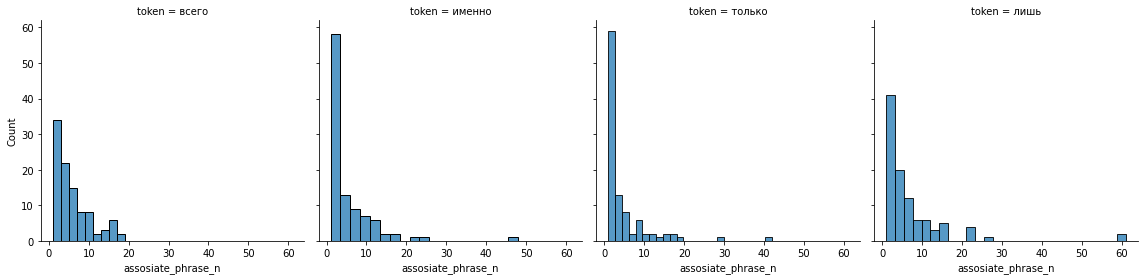

In [141]:
g = sns.FacetGrid(particles_all, col="token", height=4, aspect=1, palette="Set2")
g.map(sns.histplot, 'assosiate_phrase_n')

This plot shows that "именно" and "только" frequently attach to single-worded constituents.<br>
Whereas "всего" and "лишь" seem to attach to some bigger constituents. Maybe this is due to the fact that they like to associate with some modifiers.

Let's now investigate dependency properties.

In [142]:
# create a new dataframe
vsego_dep_type = pd.DataFrame(data = {'immediate': [], 'higher': []})

# take a set of dependency tags and set them as indices in a df
vsego_tags = set(vsego_df_updated['immediate_head_dep_type']).union(set(vsego_df_updated['higher_head_dep_type']))
vsego_dep_type.set_index = list(vsego_tags)

# add counts from an original df to a new df
vsego_counts_immediate = vsego_df_updated['immediate_head_dep_type'].value_counts()
vsego_counts_higher = vsego_df_updated['higher_head_dep_type'].value_counts()

# paste all values into a new df
for val in vsego_counts_immediate.index.values: 
    vsego_dep_type.at[val, 'immediate'] = vsego_counts_immediate[val]
for val in vsego_counts_higher.index.values: 
    vsego_dep_type.at[val, 'higher'] = vsego_counts_higher[val]

# fill na's, indicate mean value
vsego_dep_type = vsego_dep_type.fillna(0)
vsego_dep_type['mean'] = (vsego_dep_type['immediate'] + vsego_dep_type['higher']) / 2

# take into account only dependencies that have mean > 5  
vsego_dep_type = vsego_dep_type[vsego_dep_type['mean'] > 5]


We do the same for the other particles.

In [144]:
imenno_dep_type = pd.DataFrame(data = {'immediate': [], 'higher': []})

imenno_tags = set(imenno_df_updated['immediate_head_dep_type']).union(set(imenno_df_updated['higher_head_dep_type']))
imenno_dep_type.set_index = list(imenno_tags)

imenno_counts_imm = imenno_df_updated['immediate_head_dep_type'].value_counts()
imenno_counts_hi = imenno_df_updated['higher_head_dep_type'].value_counts()

for val in imenno_counts_imm.index.values: 
    imenno_dep_type.at[val, 'immediate'] = imenno_counts_imm[val]
for val in imenno_counts_hi.index.values: 
    imenno_dep_type.at[val, 'higher'] = imenno_counts_hi[val]

imenno_dep_type = imenno_dep_type.fillna(0)
imenno_dep_type['mean'] = (imenno_dep_type['immediate'] + imenno_dep_type['higher']) / 2

imenno_dep_type = imenno_dep_type[imenno_dep_type['mean'] > 5]

In [145]:
tolko_dep_type = pd.DataFrame(data = {'immediate': [], 'higher': []})

tolko_tags = set(tolko_df_updated['immediate_head_dep_type']).union(set(tolko_df_updated['higher_head_dep_type']))
tolko_dep_type.set_index = list(tolko_tags)

tolko_counts_imm = tolko_df_updated['immediate_head_dep_type'].value_counts()
tolko_counts_hi = tolko_df_updated['higher_head_dep_type'].value_counts()

for val in tolko_counts_imm.index.values: 
    tolko_dep_type.at[val, 'immediate'] = tolko_counts_imm[val]
for val in tolko_counts_hi.index.values: 
    tolko_dep_type.at[val, 'higher'] = tolko_counts_hi[val]
    
tolko_dep_type = tolko_dep_type.fillna(0)
tolko_dep_type['mean'] = (tolko_dep_type['immediate'] + tolko_dep_type['higher']) / 2

tolko_dep_type = tolko_dep_type[tolko_dep_type['mean'] > 5]

In [146]:
lish_dep_type = pd.DataFrame(data = {'immediate': [], 'higher': []})

lish_tags = set(lish_df_updated['immediate_head_dep_type']).union(set(lish_df_updated['higher_head_dep_type']))
lish_dep_type.set_index = list(lish_tags)

lish_counts_imm = lish_df_updated['immediate_head_dep_type'].value_counts()
lish_counts_hi = lish_df_updated['higher_head_dep_type'].value_counts()

for val in lish_counts_imm.index.values: 
    lish_dep_type.at[val, 'immediate'] = lish_counts_imm[val]
for val in lish_counts_hi.index.values: 
    lish_dep_type.at[val, 'higher'] = lish_counts_hi[val] 
    
lish_dep_type = lish_dep_type.fillna(0)
lish_dep_type['mean'] = (lish_dep_type['immediate'] + lish_dep_type['higher']) / 2

lish_dep_type = lish_dep_type[lish_dep_type['mean'] > 5]

In [147]:
# print(vsego_dep_type.head())
# print(imenno_dep_type.head())
# print(tolko_dep_type.head())
# print(lish_dep_type.head())

Let's create some fancy heatmaps. 

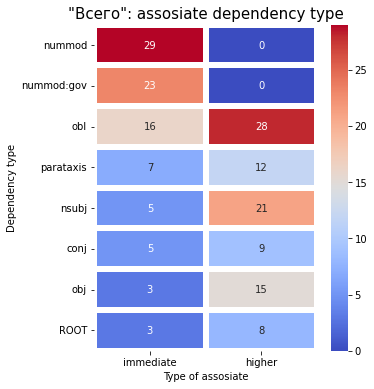

In [150]:
plt.rcParams['figure.figsize'] = [5, 6]

data = vsego_dep_type.drop(columns='mean')
sns.heatmap(data, annot=True, cmap="coolwarm", linewidths=6, linecolor='white')

plt.title('\"Всего\": assosiate dependency type', fontsize=15)
plt.yticks(rotation=0)
plt.xlabel("Type of assosiate")
plt.ylabel("Dependency type")
plt.show()

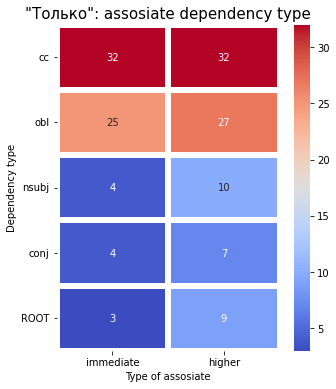

In [152]:
data = tolko_dep_type.drop(columns='mean')
sns.heatmap(data, annot=True, cmap="coolwarm", linewidths=6, linecolor='white')

plt.title('\"Только\": assosiate dependency type', fontsize=15)
plt.yticks(rotation=0)
plt.xlabel("Type of assosiate")
plt.ylabel("Dependency type")
plt.show()

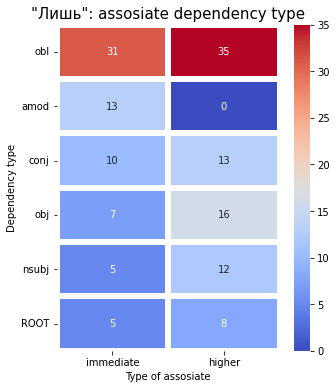

In [153]:
data = lish_dep_type.drop(columns='mean')
sns.heatmap(data, annot=True, cmap="coolwarm", linewidths=6, linecolor='white')

plt.title('\"Лишь\": assosiate dependency type', fontsize=15)
plt.yticks(rotation=0)
plt.xlabel("Type of assosiate")
plt.ylabel("Dependency type")
plt.show()


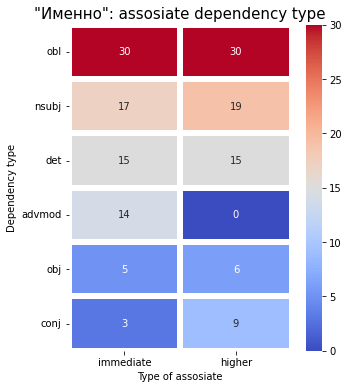

In [154]:
data = imenno_dep_type.drop(columns='mean')
sns.heatmap(data, annot=True, cmap="coolwarm", linewidths=6, linecolor='white')

plt.title('\"Именно\": assosiate dependency type', fontsize=15)
plt.yticks(rotation=0)
plt.xlabel("Type of assosiate")
plt.ylabel("Dependency type")
plt.show()


### 3.4. Interim summary


|particle|POS preferrences |constituent size|dependency type preferrences |
|:--|:--|:--|:--|
|  всего	|   NOUNs that are modified by NUMs; PRONs	|   does not frequently attach to single-worded constituents |   numeral modifiers of **obl**, **nsubj** and (to a lesser extent) **obj** |
|  только	|  NOUNs, NUMs, and PRONs; VERBs are infrequent (compared to other particles); compatibility is roughly the same for immediate and higher heads	|   single-worded as well as larger constituents	| **cc** (conjuncts), **obl** |
|  лишь   |  very frequent with NOUNs (both in terms of immediate and higher heads); combines with ADJs more readily than other particles; quite frequent with VERBs. 	|   does not frequently attach to single-worded constituents	|    **obl**; modifiers of **obl**, **obj**, **nsubj**	|
|   именно	|  Mostly, PRONs; probably, frequently occur on a clause boundary (SYM); VERBs are more frequent than with other particles	|   single-worded as well as larger constituents		|   tend to combine with **obl**; more frequent than others with **nsubj**; **det**	|


## 4. Combinations of particles
### 4.1. Data collection

Let's explore the ways in which the particles combine. 

The queries: <br>
`vsego_tolko_url`  – word1: (всего|только), word2: (всего|только), distance: 1, additional1: -bmark <br>
`vsego_imenno_url`  – word1: (всего|именно), word2: (всего|именно), distance: 1, additional1: -bmark <br>
`vsego_lish_url`  – word1: (всего|лишь), word2: (всего|лишь), distance: 1, additional1: -bmark <br>
`tolko_imenno_url`  – word1: (только|именно), word2: (именно|только), distance: 1, additional1: -bmark <br>
`tolko_lish_url`  – word1: (только|лишь), word2: (только|лишь), distance: 1, additional1: -bmark  <br>
`imenno_lish_url`  – word1: (именно|лишь), word2: (именно|лишь), distance: 1, additional1: -bmark

The links:

In [260]:
vsego_tolko_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=&spp=&spd=&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%28%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%29&gramm1=&sem1=&flags1=-bmark&sem-mod1=sem&sem-mod1=semx&parent2=0&level2=0&min2=1&max2=1&lex2=%28%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%29&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx'
vsego_imenno_url = 'https://processing.ruscorpora.ru/search.xml?flags1=-bmark&lang=ru&level1=0&level2=0&lex1=%28%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&lex2=%28%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&max2=1&min2=1&mode=main&nodia=1&p=0&parent1=0&parent2=0&sem-mod1=sem&sem-mod1=semx&sem-mod2=sem&sem-mod2=semx&sort=i_grtagging&text=lexgramm'
vsego_lish_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=&spp=&spd=&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%28%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%BB%D0%B8%D1%88%D1%8C%29&gramm1=&sem1=&flags1=-bmark&sem-mod1=sem&sem-mod1=semx&parent2=0&level2=0&min2=1&max2=1&lex2=%28%D0%B2%D1%81%D0%B5%D0%B3%D0%BE%7C%D0%BB%D0%B8%D1%88%D1%8C%29&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx'

tolko_imenno_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=&spp=&spd=&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%28%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm1=&sem1=&flags1=-bmark&sem-mod1=sem&sem-mod1=semx&parent2=0&level2=0&min2=1&max2=1&lex2=%28%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx'
tolko_lish_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=&spp=&spd=&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%28%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%BB%D0%B8%D1%88%D1%8C%29&gramm1=&sem1=&flags1=-bmark&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%28%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%7C%D0%BB%D0%B8%D1%88%D1%8C%29&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2='
imenno_lish_url = 'https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=&spp=&spd=&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm1=&sem1=&flags1=-bmark&sem-mod1=sem&sem-mod1=semx&parent2=0&level2=0&min2=1&max2=1&lex2=%28%D0%BB%D0%B8%D1%88%D1%8C%7C%D0%B8%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%29&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx'


In [252]:
vsego_tolko_df = pd.DataFrame()
vsego_tolko_df = ruscorpora_extractor(5, vsego_tolko_url)

vsego_imenno_df = pd.DataFrame()
vsego_imenno_df = ruscorpora_extractor(5, vsego_imenno_url)

vsego_lish_df = pd.DataFrame()
vsego_lish_df = ruscorpora_extractor(5, vsego_lish_url)

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


In [263]:
len(vsego_lish_df)

50

In [261]:
tolko_imenno_df = pd.DataFrame()
tolko_imenno_df = ruscorpora_extractor(5, tolko_imenno_url)

tolko_lish_df = pd.DataFrame()
tolko_lish_df = ruscorpora_extractor(5, tolko_lish_url)

imenno_lish_df  = pd.DataFrame()
imenno_lish_df  = ruscorpora_extractor(5, imenno_lish_url)

 80%|████████████████████████████████████         | 4/5 [00:03<00:00,  1.05it/s]


AttributeError: 'NoneType' object has no attribute 'find_all'

The last query seem to have less than 50 examples in the corpus. This means both combinations 'именно лишь' and 'лишь именно' are very infrequent. We will thus omit them from the  consideration. 

In [264]:
len(tolko_lish_df)

50

### 4.2. Data annotation

Let's add some annotation to the data.
Below is the function that adds  particle order (`ptcl_order`) and combination instance (`combination`) into a dataframe. 

In [265]:
def collect_combo_data(df, comboparts): 
    
    ptcl_order = []
    ptcl_order_1 = ' '.join([comboparts[0], comboparts[1]])
    ptcl_order_2 = ' '.join([comboparts[1], comboparts[0]])
    
    for ex in df['text']:
        ex_lowered = ex.lower()
    
        if ptcl_order_1 in ex_lowered:
            ptcl_order.append('-'.join([comboparts[0], comboparts[1]]))
        elif ptcl_order_2 in ex_lowered:
            ptcl_order.append('-'.join([comboparts[1], comboparts[0]]))
        else: 
            ptcl_order.append('n/a')
            
    df["ptcl_order"] = ptcl_order  
    df["combination"] = ''.join([comboparts[0], comboparts[1]])
    df = df[df["ptcl_order"] != 'n/a']
    return df

In [266]:
vt_combo = ['всего' , 'только']
vi_combo = ['всего' , 'именно']
vl_combo = ['всего' , 'лишь']
ti_combo = ['только' , 'именно']
tl_combo = ['только' , 'лишь']

vsego_tolko_df2 = collect_combo_data(vsego_tolko_df, vt_combo)
vsego_imenno_df2 = collect_combo_data(vsego_imenno_df, vi_combo)
vsego_lish_df2 = collect_combo_data(vsego_lish_df, vl_combo)
tolko_imenno_df2 = collect_combo_data(tolko_imenno_df, ti_combo)
tolko_lish_df2 = collect_combo_data(tolko_lish_df, tl_combo)

In [515]:
tolko_imenno_df2.head(10)

,text,ptcl_order,combination
0,Да вот только именно до сделки мы никак не мог...,только-именно,толькоименно
1,"Может быть, заболеть?» ― подумалось ей, но име...",именно-только,толькоименно
2,"Войцик поднял голову и тускло, даже не узнавая...",именно-только,толькоименно
3,"Вероятнее всего то, что красавица эта не была ...",именно-только,толькоименно
4,Именно только с этой стороны королевская проку...,именно-только,толькоименно
5,"Но наука, изучающая закономерности именно толь...",именно-только,толькоименно
6,Они являются здесь пред нами именно только сви...,именно-только,толькоименно
7,Именно только сегодня об этом узнал я.,именно-только,толькоименно
8,Но этот список относится именно только к перво...,именно-только,толькоименно
9,"Да и незачем ей быть теперь никакой другой, ей...",именно-только,толькоименно


### 4.3. Visualization

#### 4.3.1. Frequencies of combinations

Now let us visualize the data with pywaffle. For each pair of particles, we want to compare which one of the possible combinations is more frequent. We are going to do it with `pywaffle`.

In [163]:
!pip install pywaffle

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [517]:
from pywaffle import Waffle

# this function draws a waffle figure  
def show_waffle(data, comboparts): 
    data = data
    counts = data['ptcl_order'].value_counts()
    
    combo1 = '-'.join([comboparts[0], comboparts[1]])
    combo2 = '-'.join([comboparts[1], comboparts[0]])
    try:
        value1 = counts[combo1]
    except KeyError: 
        value1 = 0
    
    try:
        value2 = counts[combo2]
    except KeyError: 
        value2 = 0
        
    fig = plt.figure(
        FigureClass=Waffle, 
        rows=5, 
        columns=10, 
        values=[value1, value2],
        figsize=(5, 3),
        labels= [combo1, combo2],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': len(data), 'framealpha': 0},
    )
    
    plt.show()

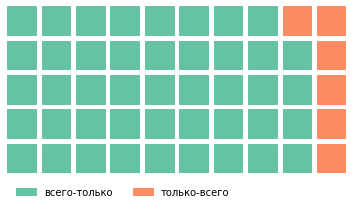

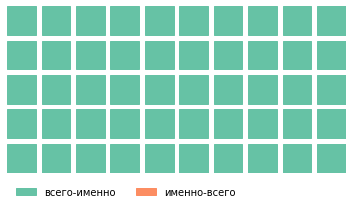

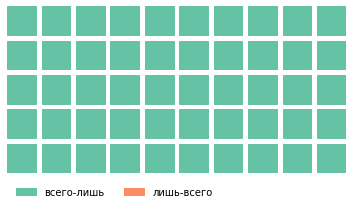

In [166]:
show_waffle(vsego_tolko_df2, vt_combo)
show_waffle(vsego_imenno_df2, vi_combo)
show_waffle(vsego_lish_df2, vl_combo)

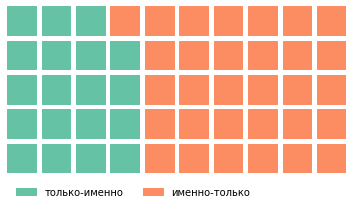

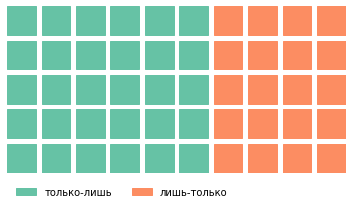

In [167]:
show_waffle(tolko_imenno_df2, ti_combo)
show_waffle(tolko_lish_df2, tl_combo)

Some observations: 
* Not all combinations are equally frequent; some do not exist at all. For instance, the particle "всего" can precede "лишь" and "именно", but the reverse orders are not possible. Both "всего только" and "только всего" are possible, but the former version is again much more frequent.

#### 4.3.2. POS prefferences of combinations of particles

Let's have a look at our combinations of particles. The following particle orders are possible: <br>
всего-только, <br>
только-всего, <br>
всего-именно, <br>
всего-лишь, <br>
только-именно, <br>
именно-только, <br>
только-лишь, <br>
лишь-только. 

We are interested in their preferences regarding POS in comparison to the corresponding standalone particles. 

Let's modify a function that gets info from SpaCy a bit, so it can work with two-worded expressions. 

In [518]:
import nltk

def collect_combination_info(spacy_model, txt, combo): 
    d_ru = spacy_model(txt)
    combo1 = ' '.join([combo[0], combo[1]])
    combo2 = ' '.join([combo[1], combo[0]])
    
    for bigram in nltk.ngrams(d_ru, 2):
        bigram_str = ' '.join([bigram[0].text, bigram[1].text])
        if bigram_str.lower() == combo1 or bigram_str.lower() == combo2:
            bigram_rindex = bigram[1].i
            
            immed_head = d_ru[bigram_rindex+1]
            higher_head = d_ru[bigram_rindex+1]
            
            while is_modifier(higher_head.dep_) != False:
                higher_head = higher_head.head
            
            if higher_head.dep_ == "ROOT": 
                subtree_list = [immed_head.head.text]
                
            else:
                subtree = higher_head.subtree
                subtree_list = []
                for t in subtree: 
                    if t.text not in combo1 or t.text not in combo2:
                        subtree_list.append(t.text)
            
            head_dict = {
                    "ptcl_order" : bigram_str.lower(),
                    "combination" : ''.join([combo[0], combo[1]]),
                    "last_ptcl_dep_type" : bigram[1].dep_,

                    "immediate_head_text" : immed_head.text,
                    "immediate_head_pos" : immed_head.pos_, 
                    "immediate_head_dep_type" : immed_head.dep_,

                    "higher_head_text" : higher_head.text,
                    "higher_head_pos" : higher_head.pos_, 
                    "higher_head_dep_type" : higher_head.dep_, 

                    "assosiate_phrase" : ' '.join(subtree_list),
                    "assosiate_phrase_n" : len(subtree_list)
            }
            break 
        
    return head_dict

Let's try it on some examples.

In [269]:
ex_txt1 = 'Осталось только лишь определить: какой из двух государственных интересов для России важнее.'
ex_txt2 = 'В современных условиях стало очевидным, что нельзя ограничиваться только лишь подготовкой учительских кадров.'
ex_txt3 = 'Но он уже не был Лениным, а только лишь тогдашним Вяхиревым, министром всего советского газа.'
ex_txt4 = 'Чиханов клянётся заплатить, лишь только будут у него деньги.'

In [175]:
# collect_combination_info(nlp_ru, ex_txt1, ['лишь', 'только'])
# collect_combination_info(nlp_ru, ex_txt2, ['лишь', 'только'])
# collect_combination_info(nlp_ru, ex_txt3, ['лишь', 'только'])
# collect_combination_info(nlp_ru, ex_txt4, ['лишь', 'только'])

It works well. Now let's create one common data frame with all particle combinations and enrich it with SpaCy data. 

In [520]:
combo_df = pd.DataFrame(data = {})

ptcl_dict = {'vsego_tolko': [vsego_tolko_df2, vt_combo],
             'vsego_imenno': [vsego_imenno_df2, vi_combo],
             'vsego_lish': [vsego_lish_df2, vl_combo],
             'tolko_imenno': [tolko_imenno_df2, ti_combo],
             'tolko_lish': [tolko_lish_df2, tl_combo]
            }

for val in ptcl_dict.values(): 
    
    df = val[0]
    combo = val[1]
    
    df_upd = pd.DataFrame()
    for txt in df['text']: 
        txt = txt.split('\n')[0]
        txt_info_dict = collect_combination_info(nlp_ru, txt, combo)
        df_upd = df_upd.append(txt_info_dict, ignore_index = True)

    combo_df = combo_df.append(df_upd)

In [508]:
combo_df.head(10)

,ptcl_order,combination,last_ptcl_dep_type,immediate_head_text,immediate_head_pos,immediate_head_dep_type,higher_head_text,higher_head_pos,higher_head_dep_type,assosiate_phrase,assosiate_phrase_n
0,всего только,всеготолько,advmod,было,AUX,cop,было,AUX,cop,Всего было,2.0
1,всего только,всеготолько,advmod,на,ADP,case,на,ADP,case,на,1.0
2,всего только,всеготолько,fixed,…,PUNCT,punct,…,PUNCT,punct,"строгий какой , а самому …",6.0
3,всего только,всеготолько,advmod,шесть,NUM,nummod:gov,лет,NOUN,obl,шесть лет,2.0
4,всего только,всеготолько,advmod,через,ADP,case,через,ADP,case,через,1.0
5,всего только,всеготолько,advmod,пятнадцать,NUM,csubj,пятнадцать,NUM,csubj,Всего пятнадцать тысяч,3.0
6,только всего,всеготолько,ROOT,:,PUNCT,punct,:,PUNCT,punct,:,1.0
7,всего только,всеготолько,advmod,на,ADP,case,на,ADP,case,на,1.0
8,всего только,всеготолько,fixed,разочек,NOUN,obj,разочек,NOUN,obj,разочек,1.0
9,всего только,всеготолько,fixed,трёх,NOUN,iobj,трёх,NOUN,iobj,"трёх постояльцев , из которых , при переезде н...",30.0


Let's analyze the data on POS preferences based on numbers from this table.

In [513]:
combo_df[combo_df['combination']=="тольколишь"].groupby('ptcl_order')['immediate_head_pos'].value_counts()

ptcl_order   immediate_head_pos
лишь только  NOUN                  7
             VERB                  6
             PRON                  4
             ADP                   2
             ADJ                   1
             ADV                   1
             AUX                   1
             DET                   1
             NUM                   1
             PROPN                 1
только лишь  VERB                  9
             NOUN                  7
             ADP                   3
             ADJ                   2
             PROPN                 2
             ADV                   1
             NUM                   1
Name: immediate_head_pos, dtype: int64

In [492]:
combo_df[combo_df['combination']=="толькоименно"].groupby('ptcl_order')['immediate_head_pos'].value_counts()

ptcl_order     immediate_head_pos
именно только  ADP                   7
               NOUN                  5
               VERB                  5
               ADJ                   4
               PRON                  3
               ADV                   1
               DET                   1
только именно  ADP                   8
               ADV                   2
               DET                   2
               NOUN                  2
               ADJ                   1
               VERB                  1
Name: immediate_head_pos, dtype: int64

In [491]:
combo_df[combo_df['combination']=="всеготолько"].groupby('ptcl_order')['immediate_head_pos'].value_counts()


ptcl_order    immediate_head_pos
всего только  NUM                   14
              NOUN                   9
              ADP                    5
              VERB                   5
              ADJ                    2
              AUX                    2
              PUNCT                  2
              ADV                    1
              PROPN                  1
только всего  NOUN                   2
              PUNCT                  2
              NUM                    1
              PART                   1
Name: immediate_head_pos, dtype: int64

In [493]:
combo_df[combo_df['combination']=="всеголишь"].groupby('ptcl_order')['immediate_head_pos'].value_counts()


ptcl_order  immediate_head_pos
всего лишь  NUM                   12
            NOUN                  11
            ADJ                    7
            ADP                    6
            VERB                   6
            ADV                    4
            DET                    1
            PROPN                  1
            PUNCT                  1
            SCONJ                  1
Name: immediate_head_pos, dtype: int64

In [494]:
combo_df[combo_df['combination']=="всегоименно"].groupby('ptcl_order')['immediate_head_pos'].value_counts()

ptcl_order    immediate_head_pos
всего именно  ADP                   30
              PRON                  10
              ADJ                    5
              DET                    5
Name: immediate_head_pos, dtype: int64

### 4.4. Summary on particle combinations

|  particles | parts of combination | features wrt pos |
|:--|:--|:--|
| лишь только | лишь, только | really infrequent; combines with NOUNs and VERBs |
| только лишь | лишь, только | mostly combines with NOUNs and VERBs |
| именно только | именно, только | mostly combines with ADP (adpositions); used with NOUNs and VERBs |
| только именно | именно, только | mostly combine with ADP (adpositions) |
| только всего | только, всего | really infrequent (more information is needed) |
| всего только | только, всего | very frequent with NUMs (numerals); quite frequent with NOUNs |
| всего лишь | всего, лишь | very frequent with NUMs (numerals); used with NOUNs, ADJs, ADPs and VERBs |
| всего именно | всего, именно | mostly combines with ADP (adpositions); used with PRONs (pronouns) |


## 5. Conclusions 

1. It seems, combinations of particles do inherit some properties of their parts. At least, different combinations containing the same particle have a somewhat similar distribution. For instance, all combinations, containing 'именно' combine with ADP (adpositions) more readily. 'всего' clearly fosters compatibility with numerals (it is also the preferable part of speech for the corresponding standalone particle).

2. Another interesting observation is that some particles seem to prefer the position within such combinations. For instance, "всего" occurs only as a first particle in a combination, whereas 'лишь', on the contrary, prefers the right place. 

